# Libraries

In [31]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## plotting utility functions

In [185]:
from matplotlib import rcParams

def plot_settings():
    font = 'DejaVu Sans'
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid")

    params = {'savefig.dpi': 300,
              'text.usetex': False,
              'mathtext.fontset': 'custom',
              'mathtext.cal': font,
              'mathtext.rm': font,
              'mathtext.tt': font,
              'mathtext.it': font + ':italic',
              'mathtext.bf': font + ':bold',
              'mathtext.sf': font,
              'font.family': font,
              'font.weight': 'bold',
              'figure.figsize': (12, 6),
              'lines.linewidth' : 2.5,
              'axes.titlesize':'large',
              'axes.labelsize':'large',
              'axes.labelsize':'large',
              'legend.fontsize':'medium',
              }
    rcParams.update(params)
    return

def save_figure(name):
    plt.savefig('figures/%s.png' % name, dpi=300)
    plt.savefig('figures/%s.pdf' % name, dpi=300)
    return

plot_settings()

# Initial conditions

In [186]:
R = 8.314459848 # Gas constant
T = 298.15  # temperature

df =  pd.read_csv('data.csv')
print(df.shape)
df.head(1)

(19, 7)


,Key,Role,Name,Hildebrand_sol,Molar_volume,Molar_weight,Density
0,a,Acceptor,TC71BM,21.28,540.186,NaN,NaN


# FOM - Mass version

If we know then molecular weight (`mol_w`) and the density of a donor material (`rho_donor`) which is related to the polarization degree, we can use the following modfied version of the FOM.


In [190]:
def chi_paramater_m(hild_donor,
                    v_acceptor,
                    hild_acceptor,
                    T=298.15,
                    R=8.314459848):
    term1 = v_acceptor / (R * T)
    term2 = (hild_donor - hild_acceptor)**2
    val = term1 * term2
    return val


def chi_spinodal_m(x, rho_donor, mol_w_donor, v_acceptor):
    term1 = 1.0 / (v_acceptor * (1 - x))
    term2 = rho_donor / (mol_w_donor * x)
    val = v_acceptor / 2.0 * (term1 + term2)
    return val


def fom_m(x,
          rho_donor,
          mol_w_donor,
          hild_donor,
          v_acceptor,
          hild_acceptor,
          T=298.15,
          R=8.314459848):
    chi_p = chi_paramater_m(hild_donor, v_acceptor, hild_acceptor, R, T)
    chi_spin = chi_spinodal_m(x, rho_donor, mol_w_donor, v_acceptor)
    val = chi_p / chi_spin
    return val

## Single material 

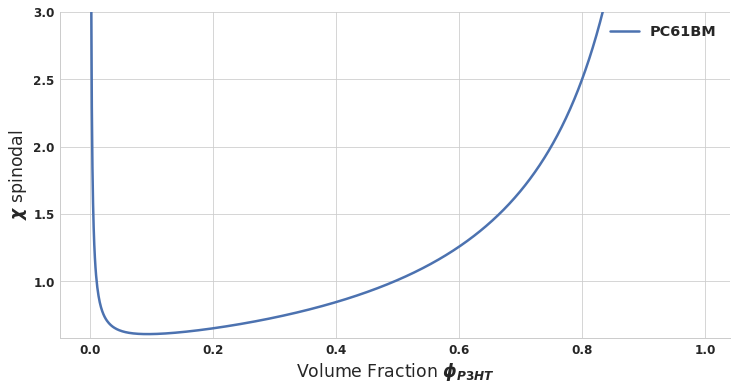

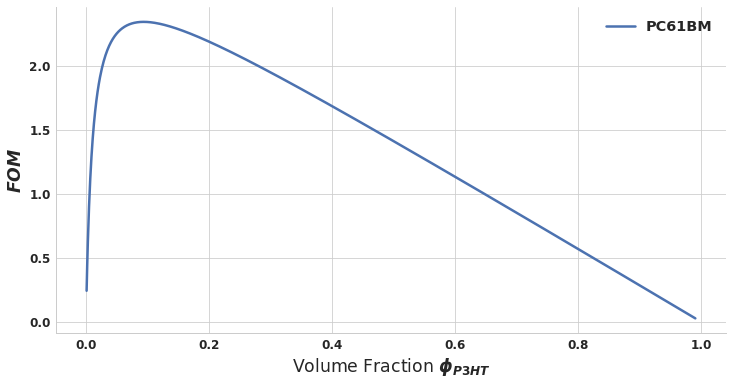

In [191]:
acceptor = df[df['Name'] == 'PC61BM'].iloc[0]
donor = df[df['Name'] == 'P3HT'].iloc[0]

x = np.linspace(0.001, 0.99, 1000)
y = chi_spinodal_m(x, donor['Density'], donor['Molar_weight'],
                   acceptor['Molar_volume'])
plt.plot(x, y, label=acceptor['Name'])
plt.legend(ncol=3, loc='best')
plt.ylim([np.min(y) * 0.95, 3])
plt.xlabel('Volume Fraction $\phi_{{ {:s} }}$'.format(donor['Name']))
plt.ylabel('$\chi$ spinodal')
sns.despine()
save_figure('chi_mass_{}_{}'.format(acceptor['Name'],donor['Name']))
plt.show()
# Figure of merit
y = fom_m(x, donor['Density'], donor['Molar_weight'], donor['Hildebrand_sol'],
          acceptor['Molar_volume'], acceptor['Hildebrand_sol'])
plt.plot(x, y, label=acceptor['Name'])
plt.legend(ncol=3, loc='best')
plt.xlabel('Volume Fraction $\phi_{{ {:s} }}$'.format(donor['Name']))
plt.ylabel('$FOM$')
sns.despine()
save_figure('fom_mass_{}_{}'.format(acceptor['Name'],donor['Name']))
plt.show()

## Several material combinations

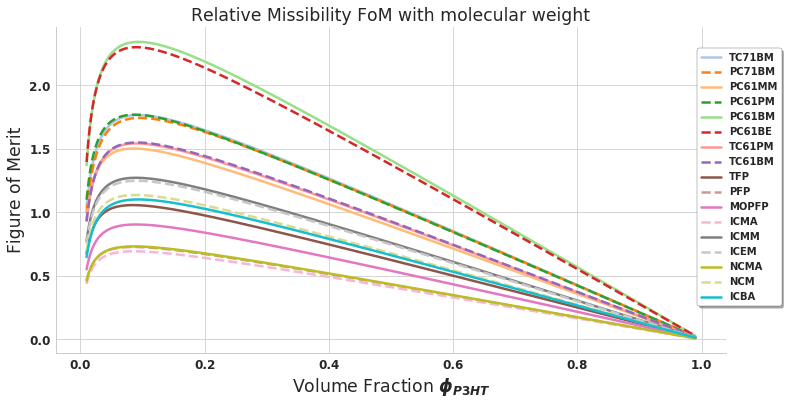

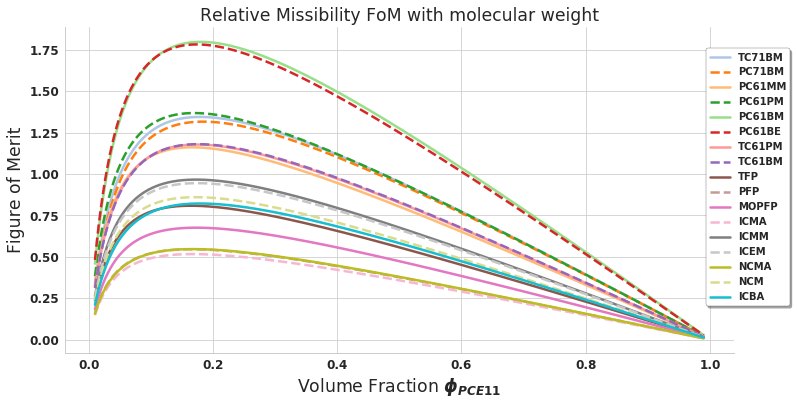

In [192]:
donors_df = df[df['Role'] == 'Donor']
acceptors_df = df[df['Role'] == 'Acceptor']
x = np.linspace(0.01, 0.99, 1000)
for indx1, donor in donors_df.iterrows():
    pal = sns.color_palette("tab20", len(acceptors_df))
    for indx2, acceptor in acceptors_df.iterrows():
        y = fom_m(x, donor['Density'], donor['Molar_weight'],
                  donor['Hildebrand_sol'], acceptor['Molar_volume'],
                  acceptor['Hildebrand_sol'])
        ln = '-' if indx2 % 2 == 0 else '--'
        plt.plot(x, y, label=acceptor['Name'], c=pal[indx2], linestyle=ln)
        #save_figure('ChiSpinodal_{}_{}.png'.format(acceptor['Name'],donor['Name']))
    plt.xlabel('Volume Fraction $\phi_{{ {:s} }}$'.format(donor['Name']))
    plt.ylabel('Figure of Merit')
    sns.despine()
    legend = plt.legend(
        ncol=1,
        loc='best',
        bbox_to_anchor=(0.95, 0.95),
        fontsize='x-small',
        fancybox=True,
        frameon=True,
        shadow=True,
        facecolor='#FFFFFF',
        edgecolor='#000000',
        framealpha=1.0)

    plt.title('Relative Missibility FoM with molecular weight')
    save_figure('FOM_mass_{}'.format(donor['Name']))
    plt.show()